In [ ]:
!unzip glove.6B.zip -d my_data


unzip:  cannot find or open glove.6B.zip, glove.6B.zip.zip or glove.6B.zip.ZIP.


In [ ]:
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import keras
from keras.layers import Dense, Embedding, Input, Flatten, LSTM, Conv1D, concatenate, MaxPooling1D
from keras.models import Sequential, Model
from keras_preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB


In [ ]:
max_len = 50
embedding_dim = 100

In [ ]:
sns.set_theme(style="whitegrid")
train = pd.read_csv('augmented_train.csv')
test = pd.read_csv("test.csv")

In [ ]:
train.head()

,Unnamed: 0,title1_en,title2_en,label
0,1383,It turns out Ma Huateng ' second daughter Ma M...,Ma Huateng tells the rumour that Wang Zhong pu...,2
1,117507,Netflix fly-by-plane fly-in-the-mud-moths-Urum...,- Texas Airplanes for Moths? - MLA: Rumors.,0
2,156419,Women on the subway do not give a seat to the ...,"A man gives a seat to a pregnant woman, and a ...",0
3,239056,"A magic grass, cure uncle's diabetes mellitus!",You know what? Here comes Diabetic Friendship....,1
4,192827,The photographer adventured to explore Fan Che...,New traffic rules are to be implemented from N...,0


In [ ]:
train.label.value_counts()

0    175598
1     74238
2     42146
Name: label, dtype: int64

In [ ]:
len(train)

291982

#### There are no missing values

In [ ]:
train.columns

Index(['Unnamed: 0', 'title1_en', 'title2_en', 'label'], dtype='object')

Text(0.5, 0, 'Labels')

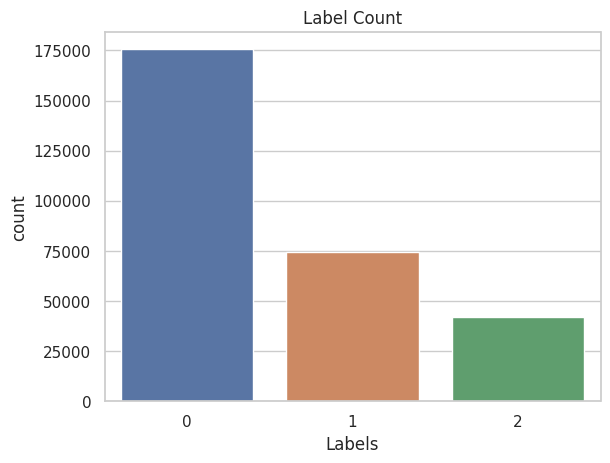

In [ ]:
sns.countplot(x=train['label'])
plt.title("Label Count")
plt.xlabel("Labels")

In [ ]:
train['label'].value_counts()

0    175598
1     74238
2     42146
Name: label, dtype: int64

In [ ]:
train.head()

,Unnamed: 0,title1_en,title2_en,label
0,1383,It turns out Ma Huateng ' second daughter Ma M...,Ma Huateng tells the rumour that Wang Zhong pu...,2
1,117507,Netflix fly-by-plane fly-in-the-mud-moths-Urum...,- Texas Airplanes for Moths? - MLA: Rumors.,0
2,156419,Women on the subway do not give a seat to the ...,"A man gives a seat to a pregnant woman, and a ...",0
3,239056,"A magic grass, cure uncle's diabetes mellitus!",You know what? Here comes Diabetic Friendship....,1
4,192827,The photographer adventured to explore Fan Che...,New traffic rules are to be implemented from N...,0


In [ ]:
train['label'].value_counts()

0    175598
1     74238
2     42146
Name: label, dtype: int64

#### The data is unbalanced

### Text preprocessing
#### Assign an index to each word
#### Count words to see most common words

In [ ]:
#  keras.datasets.imdb.load_data(num_words=max_words)
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import nltk
import string
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

UNWANTED_WORDS = ['ho', 'unk', 'ha', 'honey']
def transform_text(s):
    # Remove websites
    s = re.sub(r"http\S+", "", s) 
    s = re.sub(r"www.\S+", "", s) 
    # Remove numbers
    s = re.sub(r'\d+', '', s)
    # Remove punctuation
    s = "".join([char.lower() for char in s if char not in string.punctuation])
    tokenized = word_tokenize(s)
    tokenized =  [w for w in tokenized if not w.lower() in stop_words]
    # Apply lemmatization
    tokenized = [lemmatizer.lemmatize(w) for w in tokenized]

    return tokenized

curr = 1
lemmatizer = nltk.stem.WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
str_to_int = dict()
word_count = dict()
title1_en = []
title2_en = []
# Preprocess training
for s in train['title1_en']:
  tokenized = transform_text(s)
  l = []
  for w in tokenized:
    if w in UNWANTED_WORDS:
      l.append(0)
      continue
    if w not in str_to_int:
      str_to_int[w] = curr
      word_count[w] = 1
      curr += 1
    if w in word_count: word_count[w] += 1
    l.append(str_to_int[w])
  # if len(l) < max_len:
  title1_en.append(l)

for s in train['title2_en']:
  tokenized = transform_text(s)
  l = []
  for w in tokenized:
    if w in UNWANTED_WORDS:
      l.append(0)
      continue
    if w not in str_to_int:
      str_to_int[w] = curr
      word_count[w] = 1
      curr += 1
    if w in word_count: word_count[w] += 1
    l.append(str_to_int[w])
  # if len(l) < max_len:
  title2_en.append(l)
    
# Preprocess testing
test_title1_en = []
test_title2_en = []
for s in test['title1_en']:
  tokenized = transform_text(s)
  l = []
  for w in tokenized:
    if w in UNWANTED_WORDS:
      l.append(0)
      continue
    if w not in str_to_int:
      print("not in")
      str_to_int[w] = 0

    if w in word_count: word_count[w] += 1
    l.append(str_to_int[w])
  # if len(l) < max_len:
  test_title1_en.append(l)

for s in test['title2_en']:
  tokenized = transform_text(s)
  l = []
  for w in tokenized:
    if w in UNWANTED_WORDS:
      l.append(0)
      continue
    if w not in str_to_int:
      str_to_int[w] = 0
    if w in word_count: word_count[w] += 1
    l.append(str_to_int[w])
  test_title2_en.append(l)

    
  
    

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in
not in

In [ ]:
max_words = len(list(str_to_int.values()))
max_words

46988

In [ ]:
max_len = 0
for d in test_title1_en:
   if len(d) > max_len:
     max_len = len(d) 
     print(d)
     print(len(d))
    

for d in test_title2_en:
    if len(d) > max_len:
     max_len = len(d) 
     print(d)
     print(len(d))

for d in title1_en:
    if len(d) > max_len:
     max_len = len(d) 
     print(d)
     print(len(d))

for d in title2_en:
    if len(d) > max_len:
     max_len = len(d) 
     print(d)
     print(len(d))

print()

def find_key(input_dict, value):
  return next((k for k, v in input_dict.items() if v == value), None)

find_key(str_to_int, 2225), find_key(str_to_int, 258), find_key(str_to_int, 7682)


[714, 2380, 466, 249, 249, 5053, 6401, 59, 254, 2192, 254, 835, 36767, 5164, 924]
15
[174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 182, 186, 182, 190]
20
[955, 810, 1343, 1813, 2180, 1890, 6414, 7830, 655, 323, 0, 577, 2908, 5354, 2706, 22, 3403, 3948, 32, 7112, 779, 292, 1751, 7831, 277]
25
[2615, 7739, 9668, 1021, 5033, 1021, 4430, 3618, 198, 6934, 2229, 367, 2518, 487, 193, 1291, 1123, 866, 393, 6934, 1123, 193, 2142, 1813, 1435, 2193]
26
[3544, 2060, 2061, 1409, 1841, 1409, 1841, 1409, 1841, 1409, 1841, 1409, 1841, 1409, 1841, 1409, 1841, 1409, 1841, 1409, 1841, 1409, 1841, 1409, 1841, 1409, 1841, 1409, 1841, 1409, 1841, 1409, 1841, 1409, 1841, 1409, 1841, 1409, 1841, 1409, 1841]
41
[18664, 1202, 2187, 1780, 208, 1916, 4406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

('peasant', 'made', 'respective')

In [ ]:
# train = train[['title1_en', 'title2_en']]
# Padding training set
title1_en_padded = pad_sequences(np.array(title1_en), maxlen=max_len)
title2_en_padded = pad_sequences(np.array(title2_en), maxlen=max_len)

# Padding testing set
test_title1_en_padded = pad_sequences(np.array(test_title1_en), maxlen=max_len)
test_title2_en_padded = pad_sequences(np.array(test_title2_en), maxlen=max_len)
train_full = np.array([np.array([title1_en_padded[i], title2_en_padded[i]]) for i in range(len(title1_en_padded))])
len(train['label']), len(title1_en), len(title2_en)


<ipython-input-52-bc22a787dae5>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  title1_en_padded = pad_sequences(np.array(title1_en), maxlen=max_len)
<ipython-input-52-bc22a787dae5>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  title2_en_padded = pad_sequences(np.array(title2_en), maxlen=max_len)
<ipython-input-52-bc22a787dae5>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

(291982, 291982, 291982)

#### Our model is intended to have 2 inputs

In [ ]:
input1 = train_full[:, 0, :]
input2 = train_full[:, 1, :]

test1 = test_title1_en_padded
test2 = test_title2_en_padded

In [ ]:
print(input1[-1][-1], input2[-1][-1])

6101 431


In [ ]:
# Model
inputs1 = Input(shape=(None,), name='title1_en') # title1_en
inputs2 = Input(shape=(None,), name='title2_en') # title2_en

embedding1 = Embedding(max_words, embedding_dim-50)(inputs1)
embedding2 = Embedding(max_words, embedding_dim-50)(inputs2)

conv1 = Conv1D(128, 3, activation='relu')(embedding1)
conv2 = Conv1D(128, 3, activation='relu')(embedding2)

pool1 = MaxPooling1D()(conv1)
pool2 = MaxPooling1D()(conv2)

lstm1 = LSTM(64)(pool1)
lstm2 = LSTM(64)(pool2)

x1 = Dense(32)(lstm1)
x2 = Dense(32)(lstm2)

conc = concatenate([x1, x2], axis=-1)
x = Dense(16, activation='relu')(conc)

y = Dense(3, activation='softmax')(x)

model = Model([inputs1, inputs2], y)
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title1_en (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 title2_en (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 50)     2349400     ['title1_en[0][0]']              
                                                                                                  
 embedding_3 (Embedding)        (None, None, 50)     2349400     ['title2_en[0][0]']              
                                                                                            

In [ ]:
train['label']

0         2
1         0
2         0
3         1
4         0
         ..
291977    1
291978    1
291979    0
291980    2
291981    0
Name: label, Length: 291982, dtype: int64

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy']) 
history = model.fit([input1, input2], np.array(train['label']), epochs=5)

Epoch 1/5
9125/9125 [==============================] - 214s 23ms/step - loss: 0.5554 - accuracy: 0.7350
Epoch 2/5
9125/9125 [==============================] - 180s 20ms/step - loss: 0.3746 - accuracy: 0.8295
Epoch 3/5
9125/9125 [==============================] - 181s 20ms/step - loss: 0.3163 - accuracy: 0.8603
Epoch 4/5
9125/9125 [==============================] - 181s 20ms/step - loss: 0.2720 - accuracy: 0.8832
Epoch 5/5
9125/9125 [==============================] - 180s 20ms/step - loss: 0.2347 - accuracy: 0.9020


In [ ]:
model.save_weights("Final_model_custom_embedding.h5")

In [ ]:
y_pred = model.predict([test1, test2])

2004/2004 [==============================] - 15s 7ms/step


In [ ]:
y_pred

array([[8.7668812e-01, 1.2330588e-01, 5.9360682e-06],
       [8.8094974e-01, 1.1904865e-01, 1.5251959e-06],
       [9.9806136e-01, 1.7177541e-03, 2.2083275e-04],
       ...,
       [8.4309690e-02, 9.1568893e-01, 1.4155535e-06],
       [9.9330270e-01, 6.3395849e-03, 3.5773680e-04],
       [6.4534175e-01, 3.5430697e-01, 3.5137165e-04]], dtype=float32)

In [ ]:
d = {'id': test['id'], 'label': np.argmax(y_pred, axis=1)}
submission = pd.DataFrame(data=d, columns=['id', 'label'])
submission['label'] = submission['label'].map({0:'unrelated', 1:'agreed', 2:'disagreed'})

In [ ]:
submission.reset_index(drop=True, inplace=True)
submission.head()

,id,label
0,256442,unrelated
1,256443,unrelated
2,256444,unrelated
3,256445,unrelated
4,256446,unrelated


In [ ]:
submission.label.value_counts()

unrelated    44494
agreed       17401
disagreed     2215
Name: label, dtype: int64

In [ ]:
submission.to_csv("submission.csv", index=False)